# **Basic CUDA GPU Programming**
---

# Basic-GPGPU-CUDA

This is a step-by-step guide for beginners towards GPGPU structure and CUDA programming. Along with my own explanation, I also references some great documents and tutorials so you can discover yourself.

Some concepts are mentioned and explained in this tutorial, including:

* Basic CUDA structure;
* Thread indexing;
* Thread hierarchy;
* Shared memory and conflict management;
* Block reduction;

### Prerequisites

> Basic understanding of C/C++ is enough to start the tutorial.

### Personal notes:
>>
The course (in French only) is found [here](https://p-fb.net/master-1/gpgpu.html) by Dr. Pierre-François Bonnefoi. On a personal side, I admired his effort and passion to deliver huge course contents and detailed instruction.



Some useful links here. It's ok if one cannot understand them right away, but they will be useful later in the course. 

* [CUDA C/C++ Basic](https://www.nvidia.com/docs/IO/116711/sc11-cuda-c-basics.pdf) from NVIDIA Coproration;
* [Optimizing Parallel Reduction](https://developer.download.nvidia.com/assets/cuda/files/reduction.pdf) from NVIDIA Corporation;
* [CUDA Thread Indexing Cheat Sheet](https://cs.calvin.edu/courses/cs/374/CUDA/CUDA-Thread-Indexing-Cheatsheet.pdf) from Calvin University;

# **CUDA Installation**
---

CUDA installation may vary a bit depends on your OS and distribution. Nvidia has provided detailed instruction on both Windows and Linux environment, which can be found here:

* Linux: https://docs.nvidia.com/cuda/cuda-installation-guide-linux/index.html
* Windows: https://docs.nvidia.com/cuda/cuda-installation-guide-microsoft-windows/index.html

<u>**For those who do not possess a CUDA-capable GPU**</u>, you can make use of free GPU provided by [Google Colaboratory](https://colab.research.google.com/notebooks/gpu.ipynb).


Otherwise, [this guide](https://harshityadav95.medium.com/how-to-run-cuda-c-or-c-on-google-colab-or-azure-notebook-ea75a23a5962) shows the necessary steps to run CUDA directly on Google Colab, which is shown below:

Firstly, change the environment type to `GPU` (mentioned in the [link](https://harshityadav95.medium.com/how-to-run-cuda-c-or-c-on-google-colab-or-azure-notebook-ea75a23a5962) above).

Set up the libraries (run only once to initiate the environment):

In [ ]:
!apt-get --purge remove cuda nvidia* libnvidia-*
!dpkg -l | grep cuda- | awk '{print $2}' | xargs -n1 dpkg --purge
!apt-get remove cuda-*
!apt autoremove
!apt-get update

!wget https://developer.nvidia.com/compute/cuda/9.2/Prod/local_installers/cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64 -O cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64.deb
!dpkg -i cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64.deb
!apt-key add /var/cuda-repo-9-2-local/7fa2af80.pub
!apt-get update
!apt-get install cuda-9.2
!pip install git+git://github.com/andreinechaev/nvcc4jupyter.git
%load_ext nvcc_plugin
%!nvcc --version

>**On each session**, install [this extension](https://github.com/
andreinechaev/nvcc4jupyter) to allow CUDA compilation on Jupyter Notebook:

> Every cell with CUDA code must be initialized by `%%cu`.

In [ ]:
!pip install git+git://github.com/andreinechaev/nvcc4jupyter.git
%load_ext nvcc_plugin

  Cloning git://github.com/andreinechaev/nvcc4jupyter.git to /tmp/pip-req-build-hkznr_ud
  Running command git clone -q git://github.com/andreinechaev/nvcc4jupyter.git /tmp/pip-req-build-hkznr_ud
  Created wheel for NVCCPlugin: filename=NVCCPlugin-0.0.2-cp37-none-any.whl size=4307 sha256=c23a78410f24437b192b47c3469bacad2d8f001a98a09c0739557a978a7baaa3
  Stored in directory: /tmp/pip-ephem-wheel-cache-0v7ru7to/wheels/10/c2/05/ca241da37bff77d60d31a9174f988109c61ba989e4d4650516
Successfully built NVCCPlugin
created output directory at /content/src
Out bin /content/result.out


# **First Program**
---

There are two components participating in a CUDA program:

* **Host**: The CPU and its memory
* **Device**: The GPU and its memory

Therefore, a CUDA program consists of two parts: One part executes in GPU (parallel computing) and the other in CPU.

> We usually use prefix before each device funtion to indicate its scope. For example, `__global__` prefix means that the function executes on device (GPU), and can be called from the host (CPU).

Read more on [CUDA C/C++ Basics](https://www.nvidia.com/docs/IO/116711/sc11-cuda-c-basics.pdf).

The example below illustrate how to perform `a+b` (`a`and `b` are integers) on GPU.

* Supposing `c = a + b`. We must allocate host and device variables separately. The way we allocate memory is similar to a pointer.
* The values are initiated on CPU, then **copied** to GPU for calculation. Results are returned back to CPU.



In [ ]:
%%cu
#include<stdio.h>
#include<stdlib.h>

// __global__ prefix 
__global__ void add(int *a, int *b, int *c) {
    *c = *a + *b;
}

int main (void) {
    int a, b, c; //host variables
    int *d_a, *d_b, *d_c; //device variables
    int size = sizeof(int);

    // Memory allocation for device variables
    cudaMalloc((void **)&d_a, size);
    cudaMalloc((void **)&d_b, size);
    cudaMalloc((void **)&d_c, size);

    // Setup initial values
    a = 2;
    b = 7;

    // Copy input to device
    cudaMemcpy(d_a, &a, size, cudaMemcpyHostToDevice);
    cudaMemcpy(d_b, &b, size, cudaMemcpyHostToDevice);

    // Launch add() kernel on GPU
    add<<<1,1>>>(d_a, d_b, d_c);

    // Copy results to host
    cudaMemcpy(&c, d_c, size, cudaMemcpyDeviceToHost);

    // Cleanup
    cudaFree(d_a); cudaFree(d_b); cudaFree(d_c);

    printf("Result: %d + %d = %d", a, b, c);
    return 0;
}

Result: 2 + 7 = 9


# **Threads, blocks, and grids**
---

Useful links:
* **CUDA Basic**: https://www.nvidia.com/docs/IO/116711/sc11-cuda-c-basics.pdf

* **Kernels, Grids, Threads, Blocks**: https://docs.nvidia.com/cuda/cuda-c-programming-guide/index.html#programming-model

## ***Exercise 1: Vector addition***
> Look at the program below:

In [ ]:
%%cu
#include<stdio.h>
#define N 10

#include<stdio.h>
static void HandleError (cudaError_t err, const char *file, int line) {
    if (err != cudaSuccess) {
        printf("%s in %s at line %d\n", cudaGetErrorString(err), file, line);
        exit(EXIT_FAILURE);
    }
}

#define HANDLE_ERROR(err) (HandleError(err, __FILE__, __LINE__))
// HANDLE_ERROR(my_instruction_cuda_here());



__global__ void add(int *a, int *b, int *c) {
    int tid = blockIdx.x;
    if (tid < N)
        c[tid] = a[tid] + b[tid];
}

int main (void) {
    int a[N], b[N], c[N]; // Host variables
    int *dev_a, *dev_b, *dev_c; // Device variables

    // Memory allocation on Device
    cudaMalloc((void**)&dev_a, N * sizeof(int));
    cudaMalloc((void**)&dev_b, N * sizeof(int));
    cudaMalloc((void**)&dev_c, N * sizeof(int));

    // Fill "a" and "b" array on CPU
    for(int i=0; i<N; i++) {
        a[i] = -i;
        b[i] = i * i;
    }

    // Copy "a" and "b" array to GPU
    int size = N * sizeof(int);
    cudaMemcpy(dev_a, a, size, cudaMemcpyHostToDevice);
    cudaMemcpy(dev_b, b, size, cudaMemcpyHostToDevice);

    // Operations on GPU
    add<<<N,1>>>(dev_a, dev_b, dev_c); // Launch add() kernel on GPU with N blocks

    // Copy results back to host
    HANDLE_ERROR(cudaMemcpy(c, dev_c, size, cudaMemcpyDeviceToHost));

    // Cleanup
    cudaFree(dev_a); cudaFree(dev_b); cudaFree(dev_c);

    printf("Array a: ");
    for (int i=0; i<N; i++) {
        printf("%4d", a[i]);
    }
    printf("\n");

    printf("Array b: ");
    for (int i=0; i<N; i++) {
        printf("%4d", b[i]);
    }
    printf("\n");

    printf("Array c: ");
    for (int i=0; i<N; i++) {
        printf("%4d", c[i]);
    }
    printf("\n");

    return 0;
}

Array a:    0  -1  -2  -3  -4  -5  -6  -7  -8  -9
Array b:    0   1   4   9  16  25  36  49  64  81
Array c:    0   0   2   6  12  20  30  42  56  72



### a. Explain the purpose of `blockIdx.x` notation in kernel function `add()`

* `blockIdx.x` is used to index the array in the GPU, each block handles a different element of the array in parallel.

  * By using `blockIdx.x` to index into the array, each block handles a different element of the array, the input data are separated into multiple blocks.
  * On the device, each block can execute in parallel, for example:
      * Block 0: `c[0] = a[0] + b[0]`
      * Block 1: `c[1] = a[1] + b[1]`
      * Block 2: `c[2] = a[2] + b[2]`

#### b. In kernel function, why `if (tid < N)` is needed ?
  * Explanation on kernel call `add<<<N,1>>>(dev_a, dev_b, dev_c);` (line 45) from host: The host calls for `N` blocks for the `N` elements in each array (`a` `b` `c`, each has `N` elements). It makes sure that the number of blocks is not greater than the total elements of each array.
    * If the number of blocks **is not equal to** array length:
      * `Blocks` < `arrays`: Eg. Blocks = 5, just 5 elements of `c` is calculated, the rest is `0`.
```
Array a: 0 -1 -2 -3 -4 -5 -6 -7 -8 -9 
Array b: 0  1  4  9  16  25  36  49  64  81  
Array c: 0  0  2  6  12  0  0  0  0  0
```

      * `Blocks` > `arrays`: Just 10 blocks are used, the rest are unused.
```
Array a: 0 -1 -2 -3 -4 -5 -6 -7 -8 -9 
Array b: 0  1  4  9  16  25  36  49  64  81  
Array c: 0  0  2  6  12  20  30  42  56  72
```
    * It is possible that the number of blocks is smaller than array length. In that case, **threads** must be invoked *\_\_global\_\_* function, which is mentioned below.



#### c. Describe the program using blocks, threads, and grids notation

Based on the kernel call `add<<<N,1>>>(dev_a, dev_b, dev_c)`:

  * When a kernel is called, the device memory will be allocated a grid **(each kernel call corresponds to a grid)** The input array is divided in `N` blocks, each block contains 1 thread. The addition operation is done in parallel in the blocks.

  * **Thread indexing**: https://cs.calvin.edu/courses/cs/374/CUDA/CUDA-Thread-Indexing-Cheatsheet.pdf
  * **Thread hierachy**: https://docs.nvidia.com/cuda/cuda-c-programming-guide/index.html#thread-hierarchy

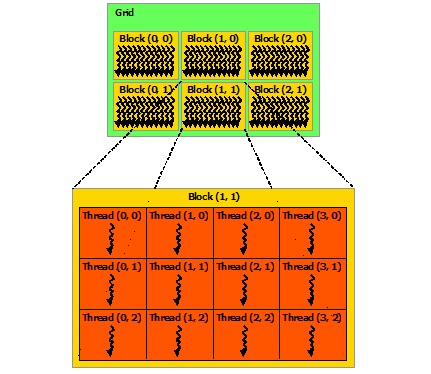

### **Summary**:

  * Host: CPU (host), controlling the device.
  * GPU: The device which performs calculation in parallel.
  * Kernel: A function with \_\_global\_\_ notation, performed by device upon request form host.
    * A kernel function is done on multiple threads in parallel.
  * **Grid** --> **Block** --> **Thread**
    * **Grid**: Each kernel call comes with a allocation of a grid.
    * **Block**: There are many blocks in a grid.
    * **Thread**: There are many threads in a block.

**Thread indexing**:

`tid = blockIdx.x * blockDim.x + threadIdx.x`

  * `blockId.x:`: Index of a block in a grid.
  * `blockDim.x`: The number of threads in a block.
  * `threadIdx.x`: Index of a thread **in a block**.
  * `tid`: Index of thread inside a grid. This is unique in a grid.

### **Kernel call:**
  * `add<<<number_of_blocks, number_of_threads>>>`
    * `add<<<1, N>>>`: One block with several threads
    * `add<<<N, 1>>>`: Several blocks with one thread each
    * `add<<<M, N>>>`: `M` blocks, each block contains `N` threads

### **Combining Threads and Blocks**
  * Each block within the grid can be identified by a one-dimensional, two-dimensional, or three-dimensional unique index accessible within the kernel through `blockIdx` variable.
    * Eg: **dim3 threadsPerBlock(16, 16);** : Number of threads per block
      * The number of threads per block and the number of blocks per grid specified in the `<<<...>>>` syntax can be of type `int` or `dim3`.


#### d. What will happen if we change the kernel call to `add<<<1,N>>>( dev_a, dev_b, dev_c );`

* `add<<<1,N>>>( dev_a, dev_b, dev_c );` means that the function executes on only 1 block which contains `N` threads running in parallel.

* Therefore we have to modify the device function `add()`. Change the `tid` variable to `tid = threadIdx.x` instead of `blockIdx.x`.

```
__global__ void add(int *a, int *b, int *c) {
    int tid = threadIdx.x;
    if (tid < N)
        c[tid] = a[tid] + b[tid];
}
```

  * There is a limit to the number of threads per block, since all threads of a block are expected to reside on the same processor core and must share the limited memory resources of that core. On current GPUs, a thread block may contain up to 1024 threads. Read more [here](https://docs.nvidia.com/cuda/cuda-c-programming-guide/index.html#thread-hierarchy).


In [ ]:
%%cu
#include<stdio.h>
#define N 10

#include<stdio.h>
static void HandleError (cudaError_t err, const char *file, int line) {
    if (err != cudaSuccess) {
        printf("%s in %s at line %d\n", cudaGetErrorString(err), file, line);
        exit(EXIT_FAILURE);
    }
}
#define HANDLE_ERROR(err) (HandleError(err, __FILE__, __LINE__))
// HANDLE_ERROR(my_instruction_cuda_here());

__global__ void add(int *a, int *b, int *c) {
    int tid = threadIdx.x;
    if (tid < N)
        c[tid] = a[tid] + b[tid];
}

int main (void) {
    int a[N], b[N], c[N]; // Host variables
    int *dev_a, *dev_b, *dev_c; // Device variables

    // Memory allocation on Device
    cudaMalloc((void**)&dev_a, N * sizeof(int));
    cudaMalloc((void**)&dev_b, N * sizeof(int));
    cudaMalloc((void**)&dev_c, N * sizeof(int));

    // Fill "a" and "b" array on CPU
    for(int i=0; i<N; i++) {
        a[i] = -i;
        b[i] = i * i;
    }

    // Copy "a" and "b" array to GPU
    int size = N * sizeof(int);
    cudaMemcpy(dev_a, a, size, cudaMemcpyHostToDevice);
    cudaMemcpy(dev_b, b, size, cudaMemcpyHostToDevice);

    // Operations on GPU
    add<<<1,N>>>(dev_a, dev_b, dev_c); // Launch add() kernel on GPU with N blocks

    // Copy results back to host
    HANDLE_ERROR(cudaMemcpy(c, dev_c, size, cudaMemcpyDeviceToHost));

    // Cleanup
    cudaFree(dev_a); cudaFree(dev_b); cudaFree(dev_c);

    printf("Array a: ");
    for (int i=0; i<N; i++) {
        printf("%4d", a[i]);
    }
    printf("\n");

    printf("Array b: ");
    for (int i=0; i<N; i++) {
        printf("%4d", b[i]);
    }
    printf("\n");

    printf("Array c: ");
    for (int i=0; i<N; i++) {
        printf("%4d", c[i]);
    }
    printf("\n");

    return 0;
}

Array a:    0  -1  -2  -3  -4  -5  -6  -7  -8  -9
Array b:    0   1   4   9  16  25  36  49  64  81
Array c:    0   0   2   6  12  20  30  42  56  72



## ***Exercise 2: Dealing with large array size***

How to deal with a large array which surpass the maximum number of threads in our GPU?

1.   Élément de liste
2.   Élément de liste



#### a. What should we do if the vector size is more than the maximum threads possible in a block (for example `N = 65536` ?
  * We can use multiple blocks in parallel if the vector size is more than `1024`.
  * Another solution is also possible: Divide the job (`N` vector elements) to our availabe threads (`1024`), therefore each thread will perform several integer addition (in series of course).

In this exercise, the first proposition will be applied.

#### b. How is the number of blocks calculated?

```
nb_threads = 128;
nb_blocks = (N + nb_threads - 1) / nb_threads;
add <<< nb_blocks, nb_threads >>> (dev_a, dev_b, dev_c);
```

* Supposing each block contains 128 threads;
* The number of allocated blocks: `nb_blocks = (N + nb_threads - 1) / nb_threads;`


#### c. Explain how `tid` is calculated below?


`int tid = threadIdx.x + blockIdx.x * blockDim.x;`
  * In this example, the vector is only one-dimensional (dimension `x`).
    * `threadIdx.x` : Index of the thread **in a block** in dimension `x`.
    * `blockIdx.x` : Index of the block **in the grid** in dimension `x`.
    * `blockDim.x` : Number of threads in a block in dimension `x`.

<u>**Note:**</u> Therefore `blockDim.x * gridDim.x` is the total number of threads in the grid.

Read more about [CUDA GridDim and BlockDim](https://stackoverflow.com/questions/16619274/cuda-griddim-and-blockdim).

> **Now read the program below:**

In [ ]:
%%cu
#define N 32768
#include<stdio.h>

__global__ void add (int *a, int *b, int *c) {
    int tid = threadIdx.x + blockIdx.x * blockDim.x;
    while (tid < N) {
        c[tid] = a[tid] + b[tid];
        tid += blockDim.x * gridDim.x;
    }
}

int main (void) {
    int a[N], b[N], c[N];
    int *dev_a, *dev_b, *dev_c;

    // Allocation de memoire sur GPU
    cudaMalloc((void**)&dev_a, N * sizeof(int));
    cudaMalloc((void**)&dev_b, N * sizeof(int));
    cudaMalloc((void**)&dev_c, N * sizeof(int));

    // Creer des valeurs pour a et b sur CPU
    for (int i=0; i<N; i++) {
        a[i] = i;
        b[i] = i*2;
    }

    // Copier des valeurs sur le device
    cudaMemcpy(dev_a, a, N*sizeof(int), cudaMemcpyHostToDevice);
    cudaMemcpy(dev_b, b, N*sizeof(int), cudaMemcpyHostToDevice);

    // Invoke Kernel
    add<<<128, 128>>>(dev_a, dev_b, dev_c);

    // Copier tableau c sur le CPU
    cudaMemcpy(c, dev_c, N*sizeof(int), cudaMemcpyDeviceToHost);

    for (int i=0; i<N; i++) {
        if (i%4096 == 0)
            printf ("%d + %d = %d\n", a[i], b[i], c[i]);
    }

    // Faire libre la memoire GPU
    cudaFree(dev_a);
    cudaFree(dev_b);
    cudaFree(dev_c);
    return 0;
}

0 + 0 = 0
4096 + 8192 = 12288
8192 + 16384 = 24576
12288 + 24576 = 36864
16384 + 32768 = 49152
20480 + 40960 = 61440
24576 + 49152 = 73728
28672 + 57344 = 86016



### d. What does this program do?
Add two integer vector with size of 32768.

### e. That is the purpose of line 6?

`int tid = threadIdx.x + blockIdx.x * blockDim.x;`
  * To calculate the index of thread globally (in the grid).

And then on line 9 in kernel function:

`tid += blockDim.x * gridDim.x;`
 
 Device call in `main()`:

 `add<<<128, 128>>>(dev_a, dev_b, dev_c);`

 * With vector size `N = 32768`, but the program execute on `128` blocks, each block contains `128` threads --> Total `128 * 128 = 16384` threads in the grid, which is less than `N`.
 * So, it is not enough space to allocate every array element in a separate cell. Therefore a single thread must perform integer addition on several array elements. But how to index the corresponding element?

> Take a look at the kernel function:

```
__global__ void add (int *a, int *b, int *c) {
    int tid = threadIdx.x + blockIdx.x * blockDim.x;
    while (tid < N) {
        c[tid] = a[tid] + b[tid];
        tid += blockDim.x * gridDim.x;
    }
}
```

   * Operation `while (tid < N)` is to ensure the index does not greater than `N`. Si c'est le cas, `tid+=16384` pour l'iteration sur d'autre `tid` qui est `16384`.
 * For example, we have `blockDim.x * gridDim.x = 128*128 = 16384` threads in total.
   * Thread `tid = 0` performs integer additions on cell 0 and 16384;
   * Thread `tid = 1` performs integer additions on cell 1 and 16385;
   * Thread `tid = 2` performs integer additions on cell 2 and 16386;

... You get the idea! The job is divided between our available threads. `16384` threads still perform in parallel!


  * Reference: https://stackoverflow.com/questions/16619274/cuda-griddim-and-blockdim
      * In particular, when the total threads in the x-dimension (`gridDim.x*blockDim.x`) is ***less than the size of the array I wish to process***, then it's common practice to create a loop and have the grid of threads move through the entire array.
      *  In effect, the entire grid of threads is jumping through the 1-D array of data, a grid-width at a time. This topic, sometimes called a "grid-striding loop", is further discussed in this [blog article](https://developer.nvidia.com/blog/cuda-pro-tip-write-flexible-kernels-grid-stride-loops/).


### f. Explain the kernel call
`add<<<128, 128>>>(dev_a, dev_b, dev_c);`

  * `N = 32768`
  * 128 blocks, each block contains 128 threads --> Total 128 * 128 = `16384` threads.
  * Addition operation from indices `0 --> 16383` are processed in parallelly in every thread. Then, the next indice is called by `tid += blockDim.x * gridDim.x;` if `tid < N`.
  * Therefore, every thread works on 2 cells: thread 0 on `0, 16384`, thread 1 on `1, 16385`, thread 2 on `2, 16386`...
  * Don't get confused! Thread `0` works on cell 0 and 16386 **in series** (firstly on cell 0, **then** cell 16386). but in the meantime, the work **between the threads** are performed in parallel.


## ***Exercise 3: Indexing***

> Look at the program below:

In [ ]:
%%cu
#include<stdio.h>

static void HandleError(cudaError_t err, const char *file, int line) {
    if (err != cudaSuccess) {
        printf("%s in %s at line %d\n", cudaGetErrorString(err), file, line);
        exit(EXIT_FAILURE);
    }
}

#define HANDLE_ERROR(err) (HandleError (err, __FILE__, __LINE__))
#define N 500

__global__ void doubler (int *a, int *c) {
    int tid = threadIdx.x;
    if (tid < N) {
        c[tid] = 2 * a[tid];
    }
}

int main() {
    int a[N], b[N], c[N];
    int *dev_a, *dev_c;
    float time;
    cudaEvent_t start, stop;

    // Allocate memory on GPU
    HANDLE_ERROR (cudaMalloc ((void**)&dev_a, N * sizeof(int)));
    HANDLE_ERROR (cudaMalloc ((void**)&dev_c, N * sizeof(int)));

    // Initialize a and b on CPU
    for (int i=0; i < N; i++) {
        a[i] = i;
        b[i] = 2*i;
    }

    // Copy a to GPU
    cudaMemcpy(dev_a, a, N * sizeof(int), cudaMemcpyHostToDevice);
    cudaEventCreate(&start);
    cudaEventCreate(&stop);
    cudaEventRecord(start, 0);

    doubler<<<1,100>>> (dev_a, dev_c);

    // Checkpoint: until the device has completed all preceding requested tasks.
    cudaThreadSynchronize(); // Returns an error if one of the preceding tasks has failed.

    printf(">%s\n",cudaGetErrorString (cudaGetLastError()));

    cudaEventRecord(stop, 0);
    cudaEventSynchronize(stop);
    cudaEventElapsedTime(&time, start, stop);

    // Copy c back to CPU
    HANDLE_ERROR(cudaMemcpy(c, dev_c, N * sizeof(int), cudaMemcpyDeviceToHost));

    // Show results
    for (int i=0; i<N; i++) {
        if ((i<=100 && i%10==0) || i%100==0)
        printf("2*%d = %d = %d\n", a[i], b[i], c[i]);
    }
    printf("Execution time: %3.1f ms\n", time);

    // Liberer espace
    cudaFree(dev_a);
    cudaFree(dev_c);
    return 0;
}

>no error
2*0 = 0 = 0
2*10 = 20 = 20
2*20 = 40 = 40
2*30 = 60 = 60
2*40 = 80 = 80
2*50 = 100 = 100
2*60 = 120 = 120
2*70 = 140 = 140
2*80 = 160 = 160
2*90 = 180 = 180
2*100 = 200 = 0
2*200 = 400 = 0
2*300 = 600 = 0
2*400 = 800 = 0
Execution time: 0.0 ms



  * If `N <= 100`, the program works correctly.
  * When `N > 100`, it gives incorrect results starting from `i=100`.



#### What went wrong?
Take a look at the kernel function:
```
__global__ void doubler (int *a, int *c) {
    int tid = threadIdx.x;
    if (tid < N) {
        c[tid] = 2 * a[tid];
    }
}
```

And the kernel call:

`doubler<<<1,100>>> (dev_a, dev_c);`

Grid configuration: 1 block, 100 threads per block --> there is only 100 threads total in a grid, hence `tid` never surpasses `100`.

Hence, only the first 100 elements of the array are calculated. There is no loop to jump to the next cells after the first 100 cells are done. 
Read more [here](ttps://stackoverflow.com/questions/16619274/cuda-griddim-and-blockdim).

<u>**Fix**:</u>
```
__global__ void doubler (int *a, int *c) {
    int tid = threadIdx.x;
    while (tid < N) {
        c[tid] = 2 * a[tid];
        tid += blockDim.x * gridDim.x;
    }
}
```

  * Change `if` to `while`;
  * Calculate `tid += blockDim.x * gridDim.x;` to "jump" to the next cells, where:
    * `gridDim.x`: Number of blocks in a grid in dimension `x`;
    * `blockDim.x`: Number of threads in a block in dimension `x`);



In [ ]:
%%cu
#include<stdio.h>

static void HandleError(cudaError_t err, const char *file, int line) {
    if (err != cudaSuccess) {
        printf("%s in %s at line %d\n", cudaGetErrorString(err), file, line);
        exit(EXIT_FAILURE);
    }
}

#define HANDLE_ERROR(err) (HandleError (err, __FILE__, __LINE__))
#define N 500

__global__ void doubler (int *a, int *c) {
    int tid = threadIdx.x;
    while (tid < N) {
        c[tid] = 2 * a[tid];
        tid += blockDim.x * gridDim.x;
    }
}

int main() {
    int a[N], b[N], c[N];
    int *dev_a, *dev_c;
    float time;
    cudaEvent_t start, stop;

    // Allocate memory on GPU
    HANDLE_ERROR (cudaMalloc ((void**)&dev_a, N * sizeof(int)));
    HANDLE_ERROR (cudaMalloc ((void**)&dev_c, N * sizeof(int)));

    // Initialize a and b on CPU
    for (int i=0; i < N; i++) {
        a[i] = i;
        b[i] = 2*i;
    }

    // Copy a to GPU
    cudaMemcpy(dev_a, a, N * sizeof(int), cudaMemcpyHostToDevice);
    cudaEventCreate(&start);
    cudaEventCreate(&stop);
    cudaEventRecord(start, 0);

    doubler<<<1,100>>> (dev_a, dev_c);

    // Checkpoint: until the device has completed all preceding requested tasks.
    cudaThreadSynchronize(); // Returns an error if one of the preceding tasks has failed.

    printf(">%s\n",cudaGetErrorString (cudaGetLastError()));

    cudaEventRecord(stop, 0);
    cudaEventSynchronize(stop);
    cudaEventElapsedTime(&time, start, stop);

    // Copy c back to CPU
    HANDLE_ERROR(cudaMemcpy(c, dev_c, N * sizeof(int), cudaMemcpyDeviceToHost));

    // Show results
    for (int i=0; i<N; i++) {
        if ((i<=100 && i%10==0) || i%100==0)
        printf("2*%d = %d = %d\n", a[i], b[i], c[i]);
    }
    printf("Execution time: %3.1f ms\n", time);

    // Liberer espace
    cudaFree(dev_a);
    cudaFree(dev_c);
    return 0;
}

>no error
2*0 = 0 = 0
2*10 = 20 = 20
2*20 = 40 = 40
2*30 = 60 = 60
2*40 = 80 = 80
2*50 = 100 = 100
2*60 = 120 = 120
2*70 = 140 = 140
2*80 = 160 = 160
2*90 = 180 = 180
2*100 = 200 = 200
2*200 = 400 = 400
2*300 = 600 = 600
2*400 = 800 = 800
Execution time: 0.0 ms



## ***Exercise 4: Conflict management and synchronization***

### a. Modify the program to calculate `c = a*a` element-wise so it works on `N=10000`.

>The kernel call should be something like `doubler<<<100,100>>()`

This time, multiple blocks are called. Therefore, we should modify the way we calculate `tid` as follows:

```
__global__ void doubler (int *a, int *c) {
    int tid = threadIdx.x + blockIdx.x*blockDim.x;
    while (tid < N) {
        c[tid] = a[tid] * a[tid];
        tid += blockDim.x * gridDim.x;
    }
}
```

In [ ]:
%%cu
#include<stdio.h>

static void HandleError(cudaError_t err, const char *file, int line) {
    if (err != cudaSuccess) {
        printf("%s in %s at line %d\n", cudaGetErrorString(err), file, line);
        exit(EXIT_FAILURE);
    }
}

#define HANDLE_ERROR(err) (HandleError (err, __FILE__, __LINE__))
#define N 10000

__global__ void doubler (int *a, int *c) {
    int tid = threadIdx.x + blockIdx.x*blockDim.x;
    while (tid < N) {
        c[tid] = a[tid] * a[tid];
        tid += blockDim.x * gridDim.x;
    }
}

int main() {
    int a[N], b[N], c[N];
    int *dev_a, *dev_c;
    float time;
    cudaEvent_t start, stop;

    // Allocate memory on GPU
    HANDLE_ERROR (cudaMalloc ((void**)&dev_a, N * sizeof(int)));
    HANDLE_ERROR (cudaMalloc ((void**)&dev_c, N * sizeof(int)));

    // Initialize a and b on CPU
    for (int i=0; i < N; i++) {
        a[i] = i;
        b[i] = i*i;
    }

    // Copy a to GPU
    cudaMemcpy(dev_a, a, N * sizeof(int), cudaMemcpyHostToDevice);
    cudaEventCreate(&start);
    cudaEventCreate(&stop);
    cudaEventRecord(start, 0);

    doubler<<<1,100>>> (dev_a, dev_c);

    // Checkpoint: until the device has completed all preceding requested tasks.
    cudaThreadSynchronize(); // Returns an error if one of the preceding tasks has failed.

    printf(">%s\n",cudaGetErrorString (cudaGetLastError()));

    cudaEventRecord(stop, 0);
    cudaEventSynchronize(stop);
    cudaEventElapsedTime(&time, start, stop);

    // Copy c back to CPU
    HANDLE_ERROR(cudaMemcpy(c, dev_c, N * sizeof(int), cudaMemcpyDeviceToHost));

    // Show results
    for (int i=0; i<N; i++) {
        if (i%1000==0)
        printf("%d*%d = %d = %d\n", a[i], a[i], b[i], c[i]);
    }
    printf("Execution time: %3.1f ms\n", time);

    // Liberer espace
    cudaFree(dev_a);
    cudaFree(dev_c);
    return 0;
}

>no error
0*0 = 0 = 0
1000*1000 = 1000000 = 1000000
2000*2000 = 4000000 = 4000000
3000*3000 = 9000000 = 9000000
4000*4000 = 16000000 = 16000000
5000*5000 = 25000000 = 25000000
6000*6000 = 36000000 = 36000000
7000*7000 = 49000000 = 49000000
8000*8000 = 64000000 = 64000000
9000*9000 = 81000000 = 81000000
Execution time: 0.1 ms



### b. Now we want to calculate the sum of all the square `a^2`.

####<center>**sum = a<sub>1</sub><sup>2</sup> + a<sub>2</sub><sup>2</sup> + ... + a<sub>N</sub><sup>2</sup>**</center>

Unlike vector addition in which the job between threads are totally independent, this exercise requires cooperation and synchronization between threads.

> Look at the kernel below:

In [ ]:
%%cu
#include<stdio.h>

// nb_blocks = 100;
// nb_threads = 100;
__global__ void square(int *a, float *c) {
    int tid = threadIdx.x + blockIdx.x*blockDim.x;
    if (tid < N) {
        c[tid] = a[tid] * a[tid];
    }
    __syncthreads();
    if (threadIdx.x == 0) {
        float temp = 0;
        for(int i=0; i<100; i++)
            temp += c[tid+i];
        c[blockIdx.x] = temp;
    }
}

#### On line 9: What is `__syncthreads();` ?
> Read more: https://stackoverflow.com/questions/15240432/does-syncthreads-synchronize-all-threads-in-the-grid

* To ensure that **all threads in a block** have finished their job before advancing to the next step. (Reminder: We are in a parallel environment, each thread does not really know what happens inside one another).
  * Note: The synchronization of `__syncthreads()` happens on **block** level.

* For example, in block `0`, if thread `0` has finished calculating **sum<sub>0</sub> = a<sub>0</sub><sup>2</sup>**, but thread `1` hasn't finished their job on **sum<sub>1</sub>**, then **sum = sum<sub>0</sub> + sum<sub>1</sub>** fails to deliver expected results. There must be a *checkpoint* mechanism.

#### Explain the `for` loop on line 14 and 15? How the sum is calculated?
* Reminder: Our kernel configuration is `<<<100, 100>>>` for `N=10000`. Therefore, there are 10000 threads to handle 10000 elements. Each thread handles an element of the array.

* Each thread `tid` calculates `c[tid] = a[tid] * a[tid]`.

* Then, the first thread on every block (line 12) calculates the sum of block `blockIdx.x`. The result is saved on `c[blockIdx.x]`.
  * **Improvements are needed**, since there are a lot of idle threads after `__syncthreads()` on line 12. Only the first thread on each block is active. This defeat the purpose of parallelism.

* The remaining job: We need to calculate the sum of all `c[blockIdx.x]`. Generally, it is not possible to do this on the same kernel since there is no synchronization mechanism between different blocks. We can do the job on CPU, or write a different kernel.

In [ ]:
%%cu
#include<stdio.h>
#define N 10000
__global__ void square(int *a, float *c) {
    int tid = threadIdx.x + blockIdx.x*blockDim.x;
    if (tid < N) {
        c[tid] = a[tid] * a[tid];
    }
    __syncthreads();
    if (threadIdx.x == 0) {
        float temp = 0;
        for(int i=0; i<blockDim.x; i++)
            temp += c[tid+i];
        c[blockIdx.x] = temp; // Save the partial sum of a block
    }
}

int main() {
    int a[N];
    int *dev_a;
    float b, c[N];
    float *dev_c;


    cudaMalloc((void**)&dev_a, N * sizeof(int));
    cudaMalloc((void**)&dev_c, N * sizeof(int));

    b = 0;
    for (int i=0;i<N;i++) {
        a[i] = i;
        b += a[i] * a[i];
    }

    cudaMemcpy(dev_a, a, N * sizeof(int), cudaMemcpyHostToDevice);

    square<<<100,100>>>(dev_a, dev_c);

    cudaMemcpy(c, dev_c, N * sizeof(int), cudaMemcpyDeviceToHost);

    // Faire la somme de tous les blocs dans le CPU
    float somme = 0;
    for (int i=0; i<100; i++) {
        somme += c[i];
    }
    printf("Results on CPU = %1.0f\nResults on GPU = %1.0f", b, somme);

    cudaFree(dev_a);
    cudaFree(dev_c);
    return 0;
}

Results on CPU = 333283328000
Results on GPU = 333283328000


#### Propose an improved version of the previous kernel using shared memory

* As mentioned above, the previous kernel is not optimized for parallelism.

> [Shared memory](https://developer.nvidia.com/blog/using-shared-memory-cuda-cc/) is accessible by all threads **in the same block**.

* How to use shared memory properly? And to avoid conflicting read-write?

Take a look at the proposed kernel below:

```
__global__ void sum(float *c, float *s) {
    __shared__ float temp; // Declare shared varibles (block-level only)
    int tid = threadIdx.x;
    if (tid < 100) {
        temp += c[tid];
    }
    __syncthreads();
    s[0] = temp;
}
```
  * That one is actually not correct. In shorts, variable `temp` is accessed concurrently by several threads at the same time, which leads to [race condition](https://stackoverflow.com/questions/34510/what-is-a-race-condition). Read the first answer of [this question](https://stackoverflow.com/questions/24051820/cuda-find-sum-of-elements-of-the-array).

#### **Fix**: <u>**Block reduction**</u>

* This [tutorial by NVIDIA](http://developer.download.nvidia.com/compute/cuda/1.1-Beta/x86_website/projects/reduction/doc/reduction.pdf) explains in detail different ways of block reduction, along with their advantages and disadvantages.

* Some more great tutorials:
 * https://www.youtube.com/watch?v=bpbit8SPMxU - Part 1
 * https://www.youtube.com/watch?v=JmnPaOXxWLg - Part 2
 * https://www.youtube.com/watch?v=iHeze1VdxYA - Part 3
 * https://www.youtube.com/watch?v=xXiA3dzl2UE - Part 4

Short explaination on each method:

> A noter : `sdata` c'est la mémoire partagée.

**1e Proposition :** Interleaved Addressing

```
__global__ void sum(float *c, float *s) {
    __shared__ float temp[blockDim.x];

    int tid = threadIdx.x + blockIdx.x*blockDim.x;
    temp[threadIdx.x] = c[tid];
    __syncthreads(); // Assurer que le tableau `temp` est remplir dans chaque block

    for (int step=1; step<blockDim.x; step*=2) {
        if (threadIdx.x % (2*step) == 0)
            temp[threadIdx.x] += temp[threadIdx.x+step];
        __syncthreads();
    }
    
    if (threadIdx.x == 0)
        s[blockIdx.x] = temp[threadIdx.x] // Sauvegarder la somme d'un block
}
```


```
for(unsigned ints=1; s < blockDim.x; s *= 2) {
    if(tid % (2*s) == 0)
        sdata[tid] += sdata[tid + s];
    __syncthreads();}
```
* Problem: Highly divergent warps are very inefficient, and % operator is very slow

**2e Proposition :** Interleaved Addressing v2
```
for(unsigned int s=1; s < blockDim.x; s *= 2) {
    int index = 2 * s * tid;
    if (index < blockDim.x)
        sdata[index] += sdata[index + s];
    __syncthreads();}
```

* New Problem: Shared Memory Bank Conflicts

**3e Proposition :** Sequential Addressing

```
for(unsigned int s=blockDim.x/2; s>0; s>>=1) {
    if (tid < s)
        sdata[tid] += sdata[tid + s];
    __syncthreads();}
```
* Problem: Half of the threads are idle on first loop iteration! This is wasteful...

**4e Proposition :**  First Add During Load

```
// perform first level of reduction
// reading from global memory, writing to shared memory
unsigned int tid = threadIdx.x;
unsigned int i = blockIdx.x*(blockDim.x*2) + threadIdx.x;
sdata[tid] = g_idata[i] + g_idata[i+blockDim.x];
__syncthreads();
```


### Implementation: Calculate the sum of an array

In [ ]:
%%cu
#include<stdio.h>
#define N 10240

__global__ void somme(float *a, float *b) {
    __shared__ float temp[1024];

    int tid = threadIdx.x + blockIdx.x*blockDim.x;
    temp[threadIdx.x] = a[tid];
    __syncthreads();

    for (int step=1; step<blockDim.x; step*=2) {
        if (threadIdx.x % (2*step) == 0)
            temp[threadIdx.x] += temp[threadIdx.x+step];
        __syncthreads();
    }

    if (threadIdx.x == 0)
        b[blockIdx.x] = temp[threadIdx.x];
}

int main () {
    float a[N], b[N], c[N];
    float *dev_a, *dev_b, *dev_c;
    float sum;

    cudaMalloc((void**)&dev_a, N * sizeof(float));
    cudaMalloc((void**)&dev_b, N * sizeof(float));
    cudaMalloc((void**)&dev_c, N * sizeof(float));

    sum = 0;
    for (int i=0;i<N;i++) {
        a[i] = 1;
        sum += a[i];
    }

    cudaMemcpy(dev_a, a, N * sizeof(float), cudaMemcpyHostToDevice);

    int block_size = 1024;
    int grid_size = (N + block_size - 1) / block_size; // = 10 blocks per grid

    somme<<<grid_size, block_size>>>(dev_a, dev_b);
    somme<<<1, block_size>>>(dev_b, dev_c);
    
    cudaMemcpy(c, dev_c, N * sizeof(float), cudaMemcpyDeviceToHost);

    
    printf("\nResults CPU = %1.0f\nResults GPU = %4.0f", sum, c[0]);

    cudaFree(dev_a);
    cudaFree(dev_b);
    cudaFree(dev_c);
}


Results CPU = 10240
Results GPU = 10240


#### Program to calculate the sum of squares

In [ ]:
%%cu
#include<stdio.h>
#define N 10000

// Proposition 1
// Improved version of the one from exercise 4, part b
// It calculates the partial sum of a block, the rest is done on CPU
// This is not the optimized method
__global__ void square(int *a, float *c) {
    __shared__ float temp[100]; //static allocation of shared memory

    int tid = threadIdx.x + blockIdx.x*blockDim.x;
    if(tid < N)
        temp[threadIdx.x] = a[tid] * a[tid];
    __syncthreads();

    if (threadIdx.x == 0) {
        for (int i=0; i<blockDim.x; i++) {
            c[blockIdx.x] += temp[i];
        }
    }
}

// Proposition 2: Calculate the sum of an array using block reduction
__global__ void sum(float *c, float *s) {
    __shared__ float temp[100];

    int tid = threadIdx.x;
    temp[threadIdx.x] = c[tid];
    __syncthreads();

    for (int step=1; step<blockDim.x; step*=2) {
        if (tid % (2*step) == 0)
            temp[tid] += temp[tid+step];
        __syncthreads();
    }

    s[0] = temp[0];
}

int main() {
    int a[N];
    int *dev_a;
    float b, c[N], s[1];
    float *dev_c, *dev_s;


    cudaMalloc((void**)&dev_a, N * sizeof(int));
    cudaMalloc((void**)&dev_c, N * sizeof(float));
    cudaMalloc((void**)&dev_s, sizeof(float));

    b = 0;
    for (int i=0;i<N;i++) {
        a[i] = i;
        b += a[i] * a[i];
    }

    cudaMemcpy(dev_a, a, N * sizeof(int), cudaMemcpyHostToDevice);

    square<<<100,100>>>(dev_a, dev_c);

    cudaMemcpy(c, dev_c, N * sizeof(float), cudaMemcpyDeviceToHost);

    sum<<<1,100>>>(dev_c, dev_s);

    cudaMemcpy(s, dev_s, sizeof(float), cudaMemcpyDeviceToHost);

    // Proposition 1: Calculate the sum in CPU
    float sum = 0;
    for (int i=0; i<100; i++) {
        sum += c[i];
    }

    printf("Resultat CPU = %1.0f\nResultat GPU v1 = %1.0f\nResultat GPU v2 = %1.0f", b, sum, s[0]);

    cudaFree(dev_a);
    cudaFree(dev_c);
    cudaFree(dev_s);
    return 0;
}

Resultat CPU = 333283328000
Resultat GPU v1 = 333283328000
Resultat GPU v2 = 333283328000


## ***Exercise 5: Matrix product***

* 3D data in CUDA: https://medium.com/@erangadulshan.14/1d-2d-and-3d-thread-allocation-for-loops-in-cuda-e0f908537a52
* Matrix multiplication on CUDA : https://www.youtube.com/watch?v=XEOc4HCf_pQ

In [ ]:
%%cu
#include<stdio.h>
#define N 8
__global__ void product(int *a, int *b, float *c) {
    int row = threadIdx.y + blockIdx.y*blockDim.y;
    int col = threadIdx.x + blockIdx.x*blockDim.x;

    float temp = 0;
    if (row<N && col<N) {
        for (int k=0; k<N; k++)
            temp += a[row*N + k] * b[k*N + col];
        c[row*N + col] = temp;
    }
}

// Matrices row-major
// https://en.wikipedia.org/wiki/Row-_and_column-major_order
int main () {
    int a[N*N], b[N*N];
    float c[N*N], c_gpu[N*N];

    int *dev_a, *dev_b;
    float *dev_c;

    // Allocation en GPU
    cudaMalloc((void**)&dev_a, N*N*sizeof(int));
    cudaMalloc((void**)&dev_b, N*N*sizeof(int));
    cudaMalloc((void**)&dev_c, N*N*sizeof(float));

    // Initialisation en CPU
    for (int row=0; row<N; row++) {
        for (int col=0; col<N; col++) {
            a[row*N + col] = row+col;
            b[row*N + col] = 2;
        }
    }

    // Produit de Matrices en CPU
    for (int row=0; row<N; row++) {
        for (int col=0; col<N; col++) {
            int sum = 0;
            for (int k=0; k<N; k++)
                sum += a[row*N + k] * b[k*N + row];
            c[row*N + col] = sum;
        }
    }

    // Copy des valeurs sur GPU
    cudaMemcpy(dev_a, a, N*N*sizeof(int), cudaMemcpyHostToDevice);
    cudaMemcpy(dev_b, b, N*N*sizeof(int), cudaMemcpyHostToDevice);

    int BLOCK_SIZE = 4;
    int GRID_SIZE = (N+BLOCK_SIZE-1)/BLOCK_SIZE;
    dim3 grid(GRID_SIZE,GRID_SIZE);
    dim3 block(BLOCK_SIZE,BLOCK_SIZE);
    product<<<grid,block>>>(dev_a, dev_b, dev_c);

    cudaMemcpy(c_gpu, dev_c, N*N*sizeof(float), cudaMemcpyDeviceToHost);

    printf("Resultat CPU:\n");
    for (int row=0; row<N; row++) {
        for (int col=0; col<N; col++) {
            printf("%3.0f  ", c[row*N + col]);
            if (col == N-1)
                printf("\n");
        }
    }

    printf("\nResultat GPU:\n");
    for (int row=0; row<N; row++) {
        for (int col=0; col<N; col++) {
            printf("%3.0f  ", c_gpu[row*N + col]);
            if (col == N-1)
                printf("\n");
        }
    }
}

Resultat CPU:
 56   56   56   56   56   56   56   56  
 72   72   72   72   72   72   72   72  
 88   88   88   88   88   88   88   88  
104  104  104  104  104  104  104  104  
120  120  120  120  120  120  120  120  
136  136  136  136  136  136  136  136  
152  152  152  152  152  152  152  152  
168  168  168  168  168  168  168  168  

Resultat GPU:
 56   56   56   56   56   56   56   56  
 72   72   72   72   72   72   72   72  
 88   88   88   88   88   88   88   88  
104  104  104  104  104  104  104  104  
120  120  120  120  120  120  120  120  
136  136  136  136  136  136  136  136  
152  152  152  152  152  152  152  152  
168  168  168  168  168  168  168  168  



## ***Exercise 6: Block Reduction - With indexing***

> Supposing we have an array of length 32.



In [ ]:
%%cu
#include <stdio.h>
#include <cuda.h>
#define SIZE 32

float tree[2*SIZE];

// Block reduction
__global__ void add(float *t, int r) {
    __shared__ float cache[SIZE*2];

    cache[threadIdx.x] = t[threadIdx.x];
    cache[threadIdx.x + SIZE] = t[threadIdx.x + SIZE];
    __syncthreads();

    while (r>1) {
        int position = threadIdx.x + r;
        if (position%2 == 0)
            cache[position/2] = cache[position] + cache[position+1];
        r /= 2;
        __syncthreads();
    }

    if (threadIdx.x == 0) {
        t[1] = cache[1];
    }
}

int main(void) {
    // float tree[2*SIZE];
    float *gpu_tree;
    cudaMalloc((void **)&gpu_tree,SIZE*2*sizeof(float));

    for(int i=SIZE;i<SIZE*2;i++)
        tree[i] = float(2);
    for(int i=0;i<SIZE*2;i++)
        printf("%4.0f",tree[i]);
    printf("\n\n");

    cudaMemcpy(gpu_tree,tree,2*SIZE*sizeof(float),cudaMemcpyHostToDevice);
    
    add<<<1,SIZE>>>(gpu_tree, SIZE);

    cudaMemcpy(tree,gpu_tree,2*SIZE*sizeof(float),cudaMemcpyDeviceToHost);

    // The results are expected to be 2*32 = 64
    for(int i=0;i<SIZE*2;i++)
        printf("%4.0f",tree[i]);
    printf("\n");

    cudaFree(gpu_tree);
}

   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2

   0  64   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2



### But what happens if the array is long?



In [ ]:
%%cu
#include <stdio.h>
#include <cuda.h>
#define SIZE 5120

float tree[2*SIZE];

__global__ void add(float *t, int r) {
    int tid = threadIdx.x + blockIdx.x*blockDim.x;

    while (r>1) {
        int position = tid + r;
        if (position%2 == 0)
            t[position/2] = t[position] + t[position+1];
        r /= 2;
        __syncthreads();
    }
}

int main(void) {
    // float tree[2*SIZE];
    float *gpu_tree;
    cudaMalloc((void **)&gpu_tree,SIZE*2*sizeof(float));


    for(int i=SIZE;i<SIZE*2;i++)
        tree[i] = float(2);

/*
    for(int i=0;i<SIZE*2;i++)
        printf("%4.0f",tree[i]);
    printf("\n\n");
*/
    cudaMemcpy(gpu_tree,tree,2*SIZE*sizeof(float),cudaMemcpyHostToDevice);
    
    int block_size = 512;
    printf("Number of threads per block: %d\n", block_size);
    int grid_size = (SIZE + block_size - 1)/block_size;
    printf("Number of blocks: %d\n", grid_size);

    add<<<grid_size,block_size>>>(gpu_tree, SIZE);

    cudaMemcpy(tree,gpu_tree,2*SIZE*sizeof(float),cudaMemcpyDeviceToHost);

    printf("\nThe first 16 cells:\n");
    for (int i=0; i<16;i++)
        printf("%6.0f",tree[i]);

    cudaFree(gpu_tree);
}

Number of threads per block: 512
Number of blocks: 10

The first 16 cells:
     0  4096  6144  4096  4096  2048  2048  2048  2048  2048  1024  1024  1024  1024  1024  1024


The result is supposed to be `2*5120 = 10240`. This one is wrong!

We see that there are multiple blocks involved, which is different from the previous exercise.

> In fact, `__syncthreads()` is limited insi
de each block. We have to synchronize the workflow accros the grid.

```
__global__ void add(float *t, int r) {
    int tid = threadIdx.x + blockIdx.x*blockDim.x;

    while (r>1) {
        int position = tid + r;
        if (position%2 == 0)
            t[position/2] = t[position] + t[position+1];
        r /= 2;
        __syncthreads();
    }
}
```

Indeed the work between the blocks is not synchronized. 

For example, `t[2048]` and `t[4096]` belong different blocks. We calculate `t[2048] = t[4096] + t[4097]`, and on the next step `t[1024] = t[2048] + t[2049]` à l'étape suivant. This "order" is not always maintained in parallel environment. 

> **Improved version**

Frankly, I didn't know why this version is not correct...

In [ ]:
%%cu
#include <stdio.h>
#include <cuda.h>
#define SIZE 1024*12

float tree[2*SIZE];

// Noyau GPU. On ajoute "num_bloc" pour calculer la position 
__global__ void add(float *t, int r, int num_bloc) {
    while (r>1) {
        int position = threadIdx.x + r + num_bloc*1024; // On abanddonne le "tid"
        if (position%2 == 0)
            t[position/2] = t[position] + t[position+1];
        r /= 2;
        __syncthreads();
    }
}

int main(void) {
    // float tree[2*SIZE];
    float *gpu_tree;
    cudaMalloc((void **)&gpu_tree,SIZE*2*sizeof(float));

    float somme_cpu = 0;
    for(int i=SIZE;i<SIZE*2;i++) {
        tree[i] = float(2);
        somme_cpu += tree[i];
    }
    cudaMemcpy(gpu_tree,tree,2*SIZE*sizeof(float),cudaMemcpyHostToDevice);
    
    int block_size = 1024;
    printf("Number of threads per block: %d\n", block_size);
    int num_bloc = (SIZE + block_size - 1)/block_size;
    printf("Number of blocks %d\n", num_bloc);

    if (num_bloc == 1) {
        add<<<num_bloc,block_size>>>(gpu_tree, SIZE, 0);
    }
    else {
        int t = SIZE;
        while (t>1) {
            for (int i=0; i<num_bloc; i++)
                add<<<1, block_size>>>(gpu_tree, SIZE, i);
            t = t/2;      
        }
    }
    cudaMemcpy(tree,gpu_tree,2*SIZE*sizeof(float),cudaMemcpyDeviceToHost);

    printf("Results CPU: %6.0f\n", somme_cpu);
    printf("Results GPU: %6.0f\n", tree[2]);
    for (int i=0; i<20;i++)
        printf("%6.0f",tree[2]);

    cudaFree(gpu_tree);
}

Nombre de threads par block: 1024
Nombre de blocks: 12
Somme CPU:  24576
Somme GPU:  16384
 16384 16384 16384 16384 16384 16384 16384 16384 16384 16384 16384 16384 16384 16384 16384 16384 16384 16384 16384 16384


##***Exercise 7: Matrix product***

Supposing we need to calculate the product of two matrix:

|   |  |  |
| --- | --- | --- |
| a0  | a1 | a2 |
| a3  | a4 | a5 |
| a6  | a7 | a8 |

and

|   |  |  |
| --- | --- | --- |
| b0  | b1 | b2 |
| b3  | b4 | b5 |
| b6  | b7 | b8 |

**For example**, we can allocate the shared memory as follows (with `3x3` matrix):

|         	| t0   	| t1   	| t2   	| t3   	| t4   	| t5   	| t6   	| t7   	| t8   	|
|---------	|------	|------	|------	|------	|------	|------	|------	|------	|------	|
| **block 0** 	| a0b0 	| a0b1 	| a0b2 	| a1b3 	| a1b4 	| a1b5 	| a2b6 	| a2b7 	| a2b8 	|
| **block 1** 	| a3b0 	| a3b1 	| a3b2 	| a4b3 	| a4b4 	| a4b5 	| a5b6 	| a5b7 	| a5b8 	|
| **block 2** 	| a6b0 	| a6b1 	| a8b2 	| a7b3 	| a7b4 	| a7b5 	| a8b6 	| a8b7 	| a8a8 	|

Then, we calculate  `t0   t1   t2`
```
t0 = t0 + t3 + t6
t1 = t1 + t4 + t7
t2 = t2 + t5 + t8
```

In [ ]:
%%cu
#include<stdio.h>
#define row 3
#define col 3

__global__ void produit(int *a, int *b, float *c) {
    __shared__ float temp[row*col];
    int num_bloc = blockIdx.x;

    // Coefficients
    int tid = threadIdx.x;
    int b_coeff = threadIdx.x; // Coefficient de "b"
    int a_coeff = (threadIdx.x/col) + num_bloc*col; // Coefficient de "a"

    // Partial product
    temp[tid] = a[a_coeff] * b[b_coeff];
    __syncthreads();

    // Sum of partial product in "temp"
    if (tid < col) {
        for (int i=1; i<col; i++) // Mdr il faut accumuler la somme a partir de i=1, sinon temp[0] += temp[0] + temp[3] + temp[6]
            temp[tid] += temp[tid + i*col]; // Accumulation de somme
        __syncthreads();
        c[tid + num_bloc*col] = temp[tid]; // Sauvegarder le resultat a une case
    }
}

int main () {
    int a[row*col], b[row*col];
    float  c_cpu[row*col], c_gpu[row*col];
    int *a_dev, *b_dev;
    float *c_dev;

    cudaMalloc((void **)&a_dev,row*col*sizeof(int));
    cudaMalloc((void **)&b_dev,row*col*sizeof(int));
    cudaMalloc((void **)&c_dev,row*col*sizeof(float));

    // Initialization
    for (int i=0; i<row; i++) {
        for (int j=0; j<col; j++) {
            a[i*row + j] = i+j;
            b[i*row + j] = 2;
        }
    }
/*
    for (int row=0; row<N; row++) {
        for (int col=0; col<N; col++) {
            int sum = 0;
            for (int k=0; k<N; k++)
                sum += a[row*N + k] * b[k*N + row];
            c[row*N + col] = sum;
        }
    }
*/
    // CPU sum
    for (int i=0; i<row; i++) {
        for (int j=0; j<col; j++) {
            int temp = 0;
            for (int k=0; k<col; k++) {
                temp += a[i*row + k] * b[k*col + i];
            }
            c_cpu[i*row + j] = temp;
        }
    }

    cudaMemcpy(a_dev,a,row*col*sizeof(int),cudaMemcpyHostToDevice);
    cudaMemcpy(b_dev,b,row*col*sizeof(int),cudaMemcpyHostToDevice);

    int block_size = col*row;
    int grid_size = row;
    produit<<<grid_size, block_size>>>(a_dev, b_dev, c_dev);

    cudaMemcpy(c_gpu,c_dev,row*col*sizeof(float),cudaMemcpyDeviceToHost);

    printf("Resultat CPU:\n");
    for (int i=0;i<row; i++) {
        for (int j=0;j<col; j++) {
            printf("%5.0f",c_cpu[i*row + j]);
        }
        printf("\n");
    }

    printf("\nResultat GPU:\n");
    for (int i=0;i<row; i++) {
        for (int j=0;j<col; j++) {
            printf("%5.0f",c_gpu[i*row + j]);
        }
        printf("\n");
    }

    cudaFree(a_dev);
    cudaFree(b_dev);
    cudaFree(c_dev);
}

Resultat CPU:
    6    6    6
   12   12   12
   18   18   18

Resultat GPU:
    6    6    6
   12   12   12
   18   18   18



##***Exercise 8: Code analysis***

> Look at the code below

```
1 #define SIZE 16384
float data[SIZE];
...
__global__ void do( float* a, float *b)
{
    int localisation = blockIdx.y * gridDim.x + blockIdx.x;
    int thread_reference = localisation * blockDim.y * blockDim.x + threadIdx.y * blockDim.x + threadIdx.x;
    ...
    /* Do something on a[thread_reference] and b[thread_reference] */
    ...
}
    ...
    dim3 dimBlock(16,16);
    dim3 dimGrid(8,8);
    do<<<dimGrid, dimBlock>>>(ref_input, ref_output);
    ...
```

###a. In the program, how the matrix is represented by a one-dimensional array? How is it possible? 

> CUDA Thread Indexing Cheat Sheet: https://cs.calvin.edu/courses/cs/374/CUDA/CUDA-Thread-Indexing-Cheatsheet.pdf


###b. How many threads are going to be executed ?
```
dim3 dimBlock(16,16);
dim3 dimGrid(8,8);
```
* Number of blocks in the grid: `8x8 = 64`
* In each block, there are `16x16 = 256` threads
* In total, there are`64x256 = 16384` threads.

##***Exercise 9: Write a kernel***

> Write a kernel to verify if a 2D array is Sudoku matrix or not

We test our program on `16x16` matrix, therefore a single block with shared memory is enough.

* Shared memory `temp` is for saving the input array; 

* Each thread runs on a `tid` cell of the input array `a` and determines: If there is a collision `temp[tid]` in hortizontal and vertical direction, along with collision in a square `4x4`.


In [ ]:
%%cu
#include<stdio.h>
#define N 16
__global__ void check(int *a, int *s) {
    int tid = threadIdx.y * blockDim.x + threadIdx.x; // A single block with shared memory
    __shared__ int temp[N*N];

    // Copy input value into shared memory
    temp[tid] = a[tid];
    __syncthreads();

    // Horizontal : Compare the cell with neighbor values "on the left"
    for (int i=0; i<threadIdx.x; i++) {
        if (temp[threadIdx.y*blockDim.x + i] == temp[tid]) {
            s += 1;
            break;
        }
    }
    // Vetical : Compare the cell with neighbor values "above"
    for (int j=0; j < threadIdx.y; j++) {
        if (temp[threadIdx.x*blockDim.y + j] == temp[tid]) {
            s[0] += 1;
            break;
        }
    }

    // Square
    int square_y = threadIdx.y / 4; // Square coordinates on dimension y
    int square_x = threadIdx.x / 4; // Square coordinates on dimension x
    // int tid_square = 4 * blockDim.x * square_y + 4*square_x; // tid of the first cell in the square

    // Comparison inside the sqaure
    for (int i=0; i<4; i++) { // Row of square
        for (int j=0; j<4; j++) { // Column of square
            int tid_cell = 4*blockDim.x*square_y + i*blockDim.x + 4*square_x + j; // tid of the cell
            if (tid_cell != tid) { // Skip the current case
                if (temp[tid_cell] == temp[tid]) {
                    s += 1;
                    break;
                }
            }
        }
    }
}

int main () {
    int a[N*N];
    int s[1];
    int *a_dev, *s_dev;

    s[0] = 0;
    cudaMalloc((void **)&a_dev,N*N*sizeof(int));
    cudaMalloc((void **)&s_dev,sizeof(int));

    // Initialisation
    for (int i=0; i<N*N; i++)
        a[i] = i;
    
    cudaMemcpy(a_dev,a,N*N*sizeof(int),cudaMemcpyHostToDevice);
    cudaMemcpy(s_dev,s,sizeof(int),cudaMemcpyHostToDevice);

    int block_size = N*N;
    int grid_size = 1;
    check<<<grid_size, block_size>>>(a_dev, s_dev);

    cudaMemcpy(s,s_dev,sizeof(int),cudaMemcpyDeviceToHost);

    if (s > 0)
        printf("This is a Sudoku table.\n");
    else
        printf("\nThis is not a Sudoku table.\n");
}

## ***Exercise 10: Memory Accessing Improvements***

In [ ]:
__global do(float A[N], float B[N])
{
    block_number = blockIdx.y * gridDim.x + blockIdx.x;
    thread_number = block_number * blockDim.y * blockDim.x + threadIdx.x * blockDim.y + threadIdx.y;
    resultat_intermediare = calcul(A[thread_number])
}

In [ ]:
dim3 block_size;
block_size.x = 32;
block_size.y = 32;
dim3 grid_size;
grid_size.x = 10;
grid_size.y = 10;
do<<<grid_size,block_size>>>(...)

The grid contains `10x10` blocks, in each block there are` 32x32` threads.

We see that thread access is not really efficient since it is not **continuous**.

###Improvements

```
block_number = blockIdx.y * gridDim.x + blockIdx.x;
thread_number = block_number * blockDim.y * blockDim.x + threadIdx.y * blockDim.x + threadIdx.x;
```